<font size="5"> This python notebook focuses on plotting cumulative area distribution for a given numerical simulation.</font><br> The fragment area of the experiment has been computed <i>a priori</i> and stored in a <<i>test_name</i>>_area.mat file.

In [2]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

Use custom mplstyle file for plotting

In [3]:
mplstyle_file = r'C:\Users\vinee\OneDrive\Documents\vscode\stressed network model\article_preprint.mplstyle'
plt.style.use(f'{mplstyle_file}')

Define fitting function. Here we define exponential fitting fuction
Inline: $y = a\exp{(-bA)}$

In [4]:
def exp_fit(x, a, b):
    return a*np.exp(b*x)

In [146]:
read_path = r'C:\MyData\Stressed network work\Data\simulation\area'
filename = 'T9_m5eb03e15_5_d5t125'

# read data for profile m = 5
with open(read_path + f'/{filename}.txt', 'r') as f:
    size = f.readlines()
size = [float(s.strip()) for s in size]
print(f'Total fragments: {len(size)}')

Total fragments: 584


Scaling the area in pixel to mm unit. The scaling factor $= 60/219 \approx 0.27$. 

In [147]:
size = [s*0.27**2 for s in size]

Applying minimum area cut off. For all the simulation, $A_{\text{cut}} = 2$ $\text{mm}^2$.

In [148]:
cut_off_area = 2
size_cut_off = [s for s in size if s >=cut_off_area]
max_size = max(size_cut_off)
min_size = min(size_cut_off)
print(f'Min size: {min_size}, Max size: {max_size}')
print(f'Total fragments above cut-off: {len(size_cut_off)}')

Min size: 2.0004812652334207, Max size: 185.72345924585736
Total fragments above cut-off: 129


Remove largest fragment area, if required. Usually, it is removed if there is single large fragment so as it does not affect fitting. We can also remove fragment area above certain upper limit. This is accomplished by eyeballing.


In [153]:
# if you want to remove the largest area
# size_range = [s for s in size_cut_off if s!=max_size]
# upper_limit = max_size

# if you want to put upper limit
upper_limit = 60
size_range = [s for s in size_cut_off if s <= upper_limit]

# if no upper limit, just use the original size
# size_range = size_cut_off
# upper_limit = 0

max_size = max(size_range)
min_size = min(size_range)
print(f'amin: {min_size}, amax: {max_size}')
print(f'Total fragments: {len(size_range)}')

amin: 2.0004812652334207, amax: 58.60042284893915
Total fragments: 113


Find cumulative area. <span style="color:rgb(255, 139, 30);"> Make sure to properly choose step size of distribution. </span>

In [154]:
# find cumulative area distribution
cum_area = np.linspace(min_size, max_size, 200)
cum_count = np.zeros_like(cum_area)
for i in range(len(cum_area)):
    cum_count[i] = len([s for s in size_range if s >= cum_area[i]])

total_count = cum_count[0]
print(total_count)

113.0


Fitting the distribution with $y = a\exp{(-bA)}$<br>
Taking log on both sides: $\log{y} = \log{a} - bA$<br>
$SS_{tot} = \sum_i (y_i - \bar{y})^2$, where $\bar{y}$ is the mean of actual data.<br>
$SS_{res} = \sum_i (y_i - y)^2$<br>
$R^2 = 1 - SS_{res}/SS_{tot}$

In [155]:
p, p_cov = curve_fit(exp_fit, cum_area, cum_count/total_count, p0=[1, -0.1])
print('Fitted parameters: a = ', p[0], ', b = ', p[1])
print('Covariance of parameters:', np.sqrt(np.diag(p_cov)))

# compute R^2
y_predicted = exp_fit(cum_area, *p)
ss_tot = np.sum((cum_area - np.mean(cum_area))**2)
ss_res = np.sum((np.log(cum_count)/total_count- np.log(y_predicted))**2)
r_squared = 1 - (ss_res / ss_tot)
print(f'R^2: {r_squared}')

Fitted parameters: a =  0.9742023267778933 , b =  -0.06297179669597112
Covariance of parameters: [0.01006504 0.000828  ]
R^2: 0.9818782714497672


Plotting the result

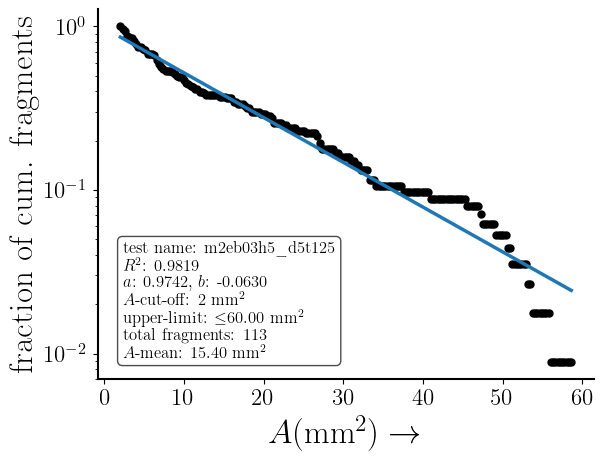

In [156]:
save_path = r'C:\MyData\Stressed network work\Data\simulation\area\results'

fig, ax = plt.subplots()
ax.plot(cum_area, cum_count/total_count, color='black', linestyle = 'none', markersize = 5, marker = 'o')
ax.plot(cum_area, exp_fit(cum_area, p[0], p[1]), color='tab:blue')

# if requried semilog scale
ax.set_yscale('log')

ax.text(
    0.05, 0.05,
    r"test name: m2eb03h5_d5t125"
    + "\n"
    + r"$R^2$: {:.4f}".format(r_squared)
    + "\n"
    + r"$a$: {:.4f}, $b$: {:.4f}".format(p[0], p[1])
    + "\n"
    + r"$A$-cut-off: {} mm$^2$".format(cut_off_area)
    + "\n"
    + r"upper-limit: $\leq ${:.2f} mm$^2$".format(upper_limit)
    + "\n"
    + r"total fragments: {}".format(int(total_count))
    + "\n"
    + r"$A$-mean: {:.2f} mm$^2$".format(np.mean(size_range)),
    transform=ax.transAxes,
    fontsize=12,
    verticalalignment='bottom',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.7)
)

ax.set_xlabel(r'$A (\rm{mm}^2)\rightarrow$')
ax.set_ylabel(r'fraction of cum. fragments')
# ax.set_xlim([0, 1])
fig.savefig(save_path+ f'/{filename}.png', dpi=300, bbox_inches='tight')
plt.show()


Saving the data

In [157]:

save_path = r'C:\MyData\Stressed network work\Data\simulation\area\results'

with open(save_path + f'/{filename}', 'wb') as f:
    pickle.dump([cum_area, cum_count, p, p_cov, size_range], f)

<font size="5"> <span style="color:rgb(255, 139, 30);"> Collate all experimental data into single plot </span>

First, we plot with varying $m$

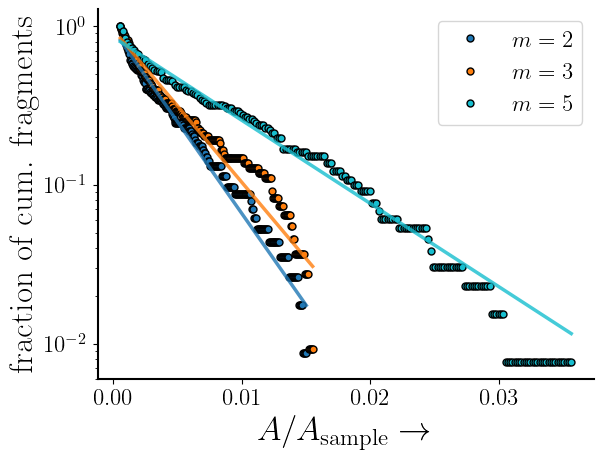

In [159]:
read_path = r'C:\MyData\Stressed network work\Data\simulation\area\results'
save_path = r'C:\MyData\Stressed network work\Data\simulation\area\results\collated'

filename = r'T1_m2eb03h5_d5t125'
with open(read_path + f'/{filename}', 'rb') as f:
    cum_area_m2, cum_count_m2, p_m2, _, _ = pickle.load(f)    # the last variable stores covariance which we don't need

filename = r'T2_m3eb03h5_d5t125'
with open(read_path + f'/{filename}', 'rb') as f:
    cum_area_m3, cum_count_m3, p_m3, _, _ = pickle.load(f)   

filename = r'T3_m5eb03h5_d5t125'
with open(read_path + f'/{filename}', 'rb') as f:
    cum_area_m5, cum_count_m5, p_m5, _, _ = pickle.load(f)  


# We can separately plot and check the data
fig, ax = plt.subplots()
A_num = 60*60   # non-dimensional by total area of the network
ax.plot(cum_area_m2/A_num, cum_count_m2/cum_count_m2[0], linestyle='none', markersize=5, marker='o', color='tab:blue', label=r'$m=2$', markeredgecolor='black')
ax.plot(cum_area_m3/A_num, cum_count_m3/cum_count_m3[0], linestyle='none', markersize=5, marker='o', color='tab:orange', label=r'$m=3$', markeredgecolor='black')
ax.plot(cum_area_m5/A_num, cum_count_m5/cum_count_m5[0], linestyle='none', markersize=5, marker='o', color='tab:cyan', label=r'$m=5$', markeredgecolor='black')
ax.plot(cum_area_m2/A_num, exp_fit(cum_area_m2, p_m2[0], p_m2[1]), color='tab:blue', alpha=0.8)
ax.plot(cum_area_m3/A_num, exp_fit(cum_area_m3, p_m3[0], p_m3[1]), color='tab:orange', alpha=0.8)
ax.plot(cum_area_m5/A_num, exp_fit(cum_area_m5, p_m5[0], p_m5[1]), color='tab:cyan', alpha=0.8)
ax.set_xlabel(r'$A/A_{\rm{sample}}\rightarrow$')
ax.set_ylabel(r'fraction of cum. fragments')

# Uncomment the following line if you want to use semilog scale
ax.set_yscale('log')

ax.legend()
fig.savefig(save_path+ '/collated_vary_m.png', dpi=300, bbox_inches='tight')
plt.show()

Second, we plot with varying $\epsilon_b$.

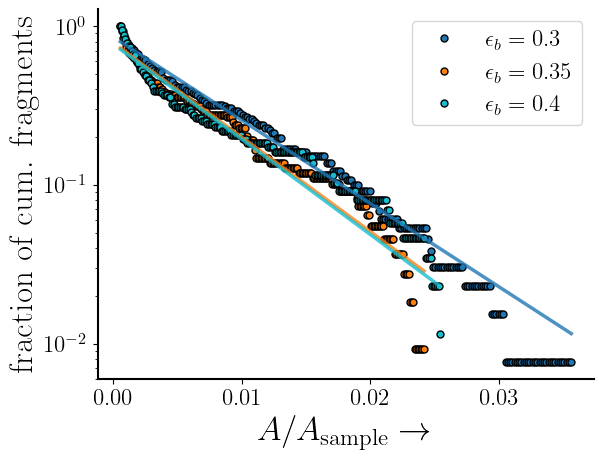

In [160]:
read_path = r'C:\MyData\Stressed network work\Data\simulation\area\results'
save_path = r'C:\MyData\Stressed network work\Data\simulation\area\results\collated'

filename = r'T3_m5eb03h5_d5t125'
with open(read_path + f'/{filename}', 'rb') as f:
    cum_area_e1, cum_count_e1, p_e1, _, _ = pickle.load(f)    # the last variable stores covariance which we don't need

filename = r'T4_m5eb035h5_d5t125'
with open(read_path + f'/{filename}', 'rb') as f:
    cum_area_e2, cum_count_e2, p_e2, _, _ = pickle.load(f)   

filename = r'T5_m5eb04h5_d5t125'
with open(read_path + f'/{filename}', 'rb') as f:
    cum_area_e3, cum_count_e3, p_e3, _, _ = pickle.load(f)  


# We can separately plot and check the data
fig, ax = plt.subplots()
A_num = 60*60   # non-dimensional by total area of the network
ax.plot(cum_area_e1/A_num, cum_count_e1/cum_count_e1[0], linestyle='none', markersize=5, marker='o', color='tab:blue', label=r'$\epsilon_b=0.3$', markeredgecolor='black')
ax.plot(cum_area_e2/A_num, cum_count_e2/cum_count_e2[0], linestyle='none', markersize=5, marker='o', color='tab:orange', label=r'$\epsilon_b=0.35$', markeredgecolor='black')
ax.plot(cum_area_e3/A_num, cum_count_e3/cum_count_e3[0], linestyle='none', markersize=5, marker='o', color='tab:cyan', label=r'$\epsilon_b=0.4$', markeredgecolor='black')
ax.plot(cum_area_e1/A_num, exp_fit(cum_area_e1, p_e1[0], p_e1[1]), color='tab:blue', alpha=0.8)
ax.plot(cum_area_e2/A_num, exp_fit(cum_area_e2, p_e2[0], p_e2[1]), color='tab:orange', alpha=0.8)
ax.plot(cum_area_e3/A_num, exp_fit(cum_area_e3, p_e3[0], p_e3[1]), color='tab:cyan', alpha=0.8)
ax.set_xlabel(r'$A/A_{\rm{sample}}\rightarrow$')
ax.set_ylabel(r'fraction of cum. fragments')

# Uncomment the following line if you want to use semilog scale
ax.set_yscale('log')

ax.legend()
fig.savefig(save_path+ '/collated_vary_eb.png', dpi=300, bbox_inches='tight')
plt.show()

Third, we plot for different impact velocity $v_0$. We have simulated two velocities:<br>
- $v_0/c_r = 0.5/25 = 0.02$<br>
- $v_0/c_r = 5/125 = 0.04$

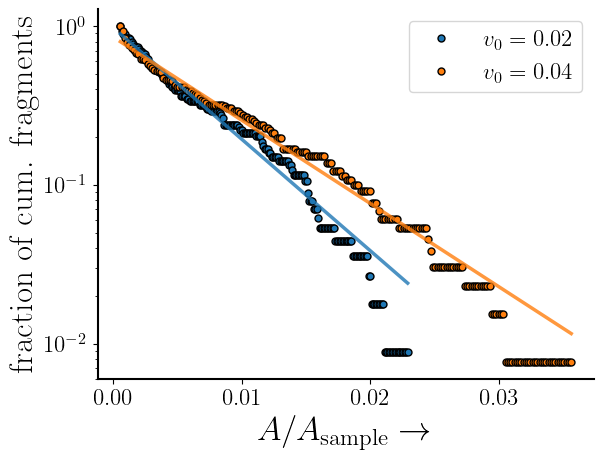

In [163]:
read_path = r'C:\MyData\Stressed network work\Data\simulation\area\results'
save_path = r'C:\MyData\Stressed network work\Data\simulation\area\results\collated'

filename = r'T6_m5eb03h5_d5t25'
with open(read_path + f'/{filename}', 'rb') as f:
    cum_area_v1, cum_count_v1, p_v1, _, _ = pickle.load(f)    # the last variable stores covariance which we don't need

filename = r'T3_m5eb03h5_d5t125'
with open(read_path + f'/{filename}', 'rb') as f:
    cum_area_v2, cum_count_v2, p_v2, _, _ = pickle.load(f)   


# We can separately plot and check the data
fig, ax = plt.subplots()
A_num = 60*60   # non-dimensional by total area of the network
ax.plot(cum_area_v1/A_num, cum_count_v1/cum_count_v1[0], linestyle='none', markersize=5, marker='o', color='tab:blue', label=r'$v_0=0.02$', markeredgecolor='black')
ax.plot(cum_area_v2/A_num, cum_count_v2/cum_count_v2[0], linestyle='none', markersize=5, marker='o', color='tab:orange', label=r'$v_0=0.04$', markeredgecolor='black')
ax.plot(cum_area_v1/A_num, exp_fit(cum_area_v1, p_v1[0], p_v1[1]), color='tab:blue', alpha=0.8)
ax.plot(cum_area_v2/A_num, exp_fit(cum_area_v2, p_v2[0], p_v2[1]), color='tab:orange', alpha=0.8)
ax.set_xlabel(r'$A/A_{\rm{sample}}\rightarrow$')
ax.set_ylabel(r'fraction of cum. fragments')

# Uncomment the following line if you want to use semilog scale
ax.set_yscale('log')

ax.legend()
fig.savefig(save_path+ '/collated_vary_v0.png', dpi=300, bbox_inches='tight')
plt.show()

Fourth plot is with different shape and size of the initiated hole.

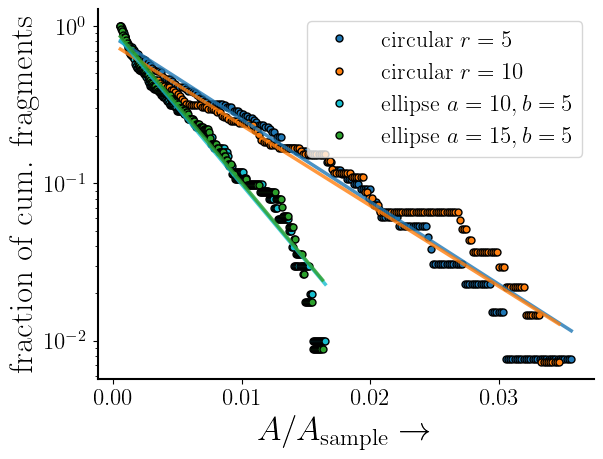

In [164]:
read_path = r'C:\MyData\Stressed network work\Data\simulation\area\results'
save_path = r'C:\MyData\Stressed network work\Data\simulation\area\results\collated'

filename = r'T3_m5eb03h5_d5t125'
with open(read_path + f'/{filename}', 'rb') as f:
    cum_area_h1, cum_count_h1, p_h1, _, _ = pickle.load(f)    # the last variable stores covariance which we don't need

filename = r'T7_m5eb03h10_d5t125'
with open(read_path + f'/{filename}', 'rb') as f:
    cum_area_h2, cum_count_h2, p_h2, _, _ = pickle.load(f)   

filename = r'T8_m5eb03e10_5_d5t125'
with open(read_path + f'/{filename}', 'rb') as f:
    cum_area_el1, cum_count_el1, p_el1, _, _ = pickle.load(f)  

filename = r'T9_m5eb03e15_5_d5t125'
with open(read_path + f'/{filename}', 'rb') as f:
    cum_area_el2, cum_count_el2, p_el2, _, _ = pickle.load(f)  


# We can separately plot and check the data
fig, ax = plt.subplots()
A_num = 60*60   # non-dimensional by total area of the network
ax.plot(cum_area_h1/A_num, cum_count_h1/cum_count_h1[0], linestyle='none', markersize=5, marker='o', color='tab:blue', label='circular $r=5$', markeredgecolor='black')
ax.plot(cum_area_h2/A_num, cum_count_h2/cum_count_h2[0], linestyle='none', markersize=5, marker='o', color='tab:orange', label='circular $r=10$', markeredgecolor='black')
ax.plot(cum_area_el1/A_num, cum_count_el1/cum_count_el1[0], linestyle='none', markersize=5, marker='o', color='tab:cyan', label='ellipse $a=10, b=5$', markeredgecolor='black')
ax.plot(cum_area_el2/A_num, cum_count_el2/cum_count_el2[0], linestyle='none', markersize=5, marker='o', color='tab:green', label='ellipse $a=15, b=5$', markeredgecolor='black')

ax.plot(cum_area_h1/A_num, exp_fit(cum_area_h1, p_h1[0], p_h1[1]), color='tab:blue', alpha=0.8)
ax.plot(cum_area_h2/A_num, exp_fit(cum_area_h2, p_h2[0], p_h2[1]), color='tab:orange', alpha=0.8)
ax.plot(cum_area_el1/A_num, exp_fit(cum_area_el1, p_el1[0], p_el1[1]), color='tab:cyan', alpha=0.8)
ax.plot(cum_area_el2/A_num, exp_fit(cum_area_el2, p_el2[0], p_el2[1]), color='tab:green', alpha=0.8)
ax.set_xlabel(r'$A/A_{\rm{sample}}\rightarrow$')
ax.set_ylabel(r'fraction of cum. fragments')

# Uncomment the following line if you want to use semilog scale
ax.set_yscale('log')

ax.legend()
fig.savefig(save_path+ '/collated_vary_shape.png', dpi=300, bbox_inches='tight')
plt.show()

<font size="5"> <span style="color:rgb(255, 139, 30);"> Plotting mean area and exponential coefficient </span>

Slope of the fit line: 1.448691773140604


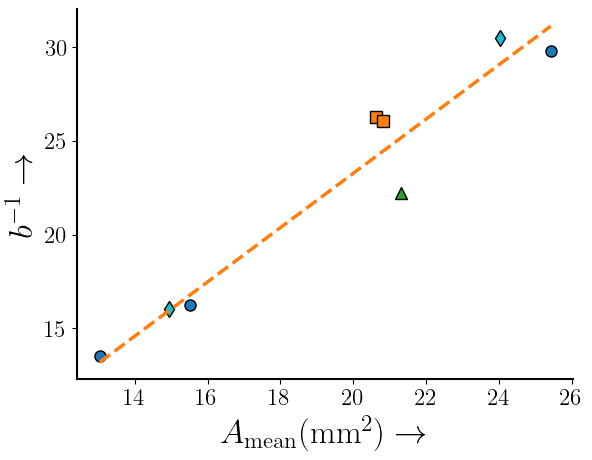

In [169]:
save_path = r'C:\MyData\Stressed network work\Data\simulation\area\results\collated'

# varying m
filename = r'T1_m2eb03h5_d5t125'
with open(read_path + f'/{filename}', 'rb') as f:
    cum_area_m2, cum_count_m2, p_m2, _, area_m2 = pickle.load(f)    # the last variable stores covariance which we don't need

filename = r'T2_m3eb03h5_d5t125'
with open(read_path + f'/{filename}', 'rb') as f:
    cum_area_m3, cum_count_m3, p_m3, _, area_m3 = pickle.load(f)   

filename = r'T3_m5eb03h5_d5t125'
with open(read_path + f'/{filename}', 'rb') as f:
    cum_area_m5, cum_count_m5, p_m5, _, area_m5 = pickle.load(f)  

# varying epsilon_b
filename = r'T4_m5eb035h5_d5t125'
with open(read_path + f'/{filename}', 'rb') as f:
    cum_area_e2, cum_count_e2, p_e2, _, area_e2 = pickle.load(f)   

filename = r'T5_m5eb04h5_d5t125'
with open(read_path + f'/{filename}', 'rb') as f:
    cum_area_e3, cum_count_e3, p_e3, _, area_e3 = pickle.load(f) 

# varying v0
filename = r'T6_m5eb03h5_d5t25'
with open(read_path + f'/{filename}', 'rb') as f:
    cum_area_v1, cum_count_v1, p_v1, _, area_v1 = pickle.load(f)    # the last variable stores covariance which we don't need

# varying shape and size
filename = r'T7_m5eb03h10_d5t125'
with open(read_path + f'/{filename}', 'rb') as f:
    cum_area_h2, cum_count_h2, p_h2, _, area_h2 = pickle.load(f)   

filename = r'T8_m5eb03e10_5_d5t125'
with open(read_path + f'/{filename}', 'rb') as f:
    cum_area_el1, cum_count_el1, p_el1, _, area_el1 = pickle.load(f)  

filename = r'T9_m5eb03e15_5_d5t125'
with open(read_path + f'/{filename}', 'rb') as f:
    cum_area_el2, cum_count_el2, p_el2, _, area_el2 = pickle.load(f) 


A_mean = np.array([
    np.mean(area_m2),
    np.mean(area_m3),
    np.mean(area_m5),
    np.mean(area_e2),
    np.mean(area_e3),
    np.mean(area_v1),
    np.mean(area_h2),
    np.mean(area_el1),
    np.mean(area_el2)
])

b = np.array([
    p_m2[1],
    p_m3[1],
    p_m5[1],
    p_e2[1],
    p_e3[1],
    p_v1[1],
    p_h2[1],
    p_el1[1],
    p_el2[1]
])
b = -1/b  # invert the slope for plotting

fig, ax = plt.subplots()
ax.plot(A_mean[:3], b[:3], linestyle='none', markersize=8, marker='o', color='tab:blue', markeredgecolor='black',
        label = r'varying $m$')
ax.plot(A_mean[3:5], b[3:5], linestyle='none', markersize=8, marker='s', color='tab:orange', markeredgecolor='black',
        label = r'varying $\epsilon_b$')
ax.plot(A_mean[5:6], b[5:6], linestyle='none', markersize=8, marker='^', color='tab:green', markeredgecolor='black',
        label = r'varying $v_0$')
ax.plot(A_mean[6:8], b[6:8], linestyle='none', markersize=8, marker='d', color='tab:cyan', markeredgecolor='black',
        label = r'varying shape')

# Add a trend line
p_trend, _ = np.polyfit(A_mean, b, 1, cov=True)
print(f"Slope of the fit line: {p_trend[0]}")

x_fit = np.linspace(min(A_mean), max(A_mean), 100)
y_fit = np.polyval(p_trend, x_fit)
ax.plot(x_fit, y_fit, color='tab:orange', linestyle='--', label='Trend line')

ax.set_xlabel(r'$A_{\rm{mean}} (\rm{mm}^2)\rightarrow$')
ax.set_ylabel(r'$b^{-1} \rightarrow$')

# Save the figure
# fig.savefig(save_path + '/mean_area_vs_b_num.png', dpi=300, bbox_inches='tight')
plt.show()